# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Apr 7 (Friday) 11:00 pm </font>  

<font color="blue"> type your name here </font>

Name:- Hari Chandana Chavva

Student ID:- 801336599

# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

# II. Problems 



## 2D Marble Control

![image.png](attachment:image.png)

#### STEPS for 2D Marble

1. [II Problems] First, build 2D marble class by extending the Marble class from the class note. 
2. [II Problems] Explain the environment.
3. [III Methods] Build your own RLAgent class to solve the problem.
4. [III Methods] Explain your RLAgent (with a neural network function approximator)
5. [IV Results]  Discuss the results 



## Gymnasium  

![image-2.png](attachment:image-2.png)

[Gymnasium](https://gymnasium.farama.org/) (former OpenAI Gym) is a playground for RL community with a number of RL environments (including the Lunar Lander below) with a well-designed and unified interface. Visit https://gymnasium.farama.org/ to explore the environments to select your choice of environment. 

<img alt="Lunar Lander" src="https://gymnasium.farama.org/_images/lunar_lander.gif" style="width: 400px;" />


#### STEPS for Gymnasium

First of all, install gymnasium by running 

> pip install gymnasium



Among [Classical Control](https://gymnasium.farama.org/environments/classic_control/) or [Toy Text](https://gymnasium.farama.org/environments/toy_text/) environments, pick one that you want to solve. 
<font color='red'>As we already practiced **MountainCar** and **FrozenLake**, these two are not allowed.</font>

1. [II Problems] Describe the selected environment.
2. [II Problems] Learn how to use the Gymnasium "YourEnv-v?" environment referring to the environment description.
3. [III Methods] Build your own RLAgent class to solve the problem with a tabular function approximator.
4. [III Methods] Explain your RLAgent 
5. [IV Results]  Discuss the results 


# I. Overview

I created a Reinforcement Learning agent for two common control problems: the 2D-Marble and Cart Pole. I developed the environment and agent for the 2D-Marble problem, while for Cart Pole, I utilized an existing environment from the gym library and created the agent. In both cases, I employed a deep neural network to serve as the function approximator.

# II. Problems
## II.I. 2D Marble Control

### II.I.II. Explanation of the environment
A class called Marble2D, which depicts a 2-dimensional marble issue, is defined in the code. The condition of the marble, which comprises the stone's position (x, y), and velocity (dx, dy). The target, or position that the marble must go to in order to succeed, is also specified.

The amount of state features and action features, the environment's boundaries (i.e., the range of acceptable values for position and velocity), and the target width are some of the attributes that the class possesses (i.e., the distance from the goal at which the marble is considered to have reached it).

The class also provides a reset() function that, unless a user specifies otherwise, resets the marble's position and speed to random numbers within the confines of the environment.

In [223]:
pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [268]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import collections
from copy import deepcopy as copy

In [269]:
class Marble2D():
    """ 2d marble problem
        
        states: [x, dx, y, dy]
            x: x-coordinate location
            dx: x velocity
            y: y-coordinate location
            dy: y velocity
            
        action: [-1,0,1]
            -1: Move left/down
            0: Do not move
            1: Move right/up


        |            ___                     |
        |___________|///|____G_______________|
                    <- ->

        Attributes:

            n_states (int): Number of state features. By default this is set to 4 as each state is represented as
                list where the 1st element is the x-coordinate (x), 2nd element is the x velocity (dx),
                3rd element is the y-coordinate (y), and 4th element is the y velocity (dy).
                
            n_actions (int): Number of action features. Represented by integer where -1 means move left/down and 
                1 means move right/up.
            
            goal (list): List containing x and y-coordinate positions of goal where marble must be within 
                self.goal_width of this goal to complete the task.
                
            goal_width (float): Used check if marble is within a certain distance of the goal. Defaults
                to a value of 1.
    
            bound (list): Contains bounds for x-coordinate, y-coordinate, and their respective velocities such 
                that these can not be exceeded. Example of list positions and their corresponding values are given below.
                
                [x-coordinate lower bound, x-coordinate upper bound, x velocity lower bound, x velocity upper bound,
                 y-coordinate lower bound, y-coordinate upper bound, y velocity lower bound, y velocity upper bound]
            
            _st_range (np.ndarray): 2D array version of bound where the rows represent the min and max values and
                the columns represent x, dx, y, and dy values.
            
            _s (list): Current start state given by the x and y coordinates and their respective velocities. By default, 
                it is initialized to [0, 0, 0, 0]. Here _s[0] corresponds to the x-coordinate, _s[1] corresponds to dx or velocity 
                in the x direction, _s[2] corresponds to the y-coordinate, and _s[3] corresponds to dy or velocity in the y direction.
    """

    def __init__(self, goal=[5,5], bound=[0, 10, -5, 5, 0, 10, -5, 5]):
        self.n_states = 4
        self.n_actions = 2
        self.goal = goal
        self.goal_width = 1
        self.bound = bound
        
        self._st_range = np.array([self.bound[:2], self.bound[2:4], self.bound[4:6], self.bound[6:]]).T
        
        self._s = [0, 0, 0, 0]

    def reset(self, start=None):
        if start is not None:
            self._s = start
        else:
            self._s = [np.random.uniform(self.bound[0], self.bound[1]),
                       np.random.uniform(self.bound[2], self.bound[3]),
                       np.random.uniform(self.bound[4], self.bound[5]),
                       np.random.uniform(self.bound[6], self.bound[7])]
        
        return self._s

   


## II.I.III. Explanation of the RLAgent1
The code defines a RLAgent class that uses a neural network to learn a Q-function via the DQN algorithm. The agent selects actions using an epsilon-greedy strategy, stores transitions in memory, and updates the model by training on a random minibatch. The class includes methods for saving and loading the model weights.

In [270]:
class RLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Build a neural network model for the DQN
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # Add a transition tuple to the memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Choose an action based on the current state using an epsilon-greedy strategy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state)[0])

    def replay(self, batch_size):
        # Train the model on a random batch of experiences from the memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        # Load weights into the model
        self.model.load_weights(name)

    def save(self, name):
        # Save weights of the model
        self.model.save_weights(name)


In [271]:
def step(self, action):
    # Get current state
    x, dx, y, dy = self._s
    
    # Update velocities based on action
    if action == -1:
        dx -= 1
        dy -= 1
    elif action == 1:
        dx += 1
        dy += 1
    
    # Apply velocity constraints
    dx = max(min(dx, self.bound[3]), self.bound[2])
    dy = max(min(dy, self.bound[7]), self.bound[6])
    
    # Update position based on velocity
    x += dx
    y += dy
    
    # Apply position constraints
    x = max(min(x, self.bound[1]), self.bound[0])
    y = max(min(y, self.bound[5]), self.bound[4])
    
    # Update state
    self._s = [x, dx, y, dy]
    
    # Calculate reward
    distance_to_goal = np.sqrt((x - self.goal[0])**2 + (y - self.goal[1])**2)
    if distance_to_goal <= self.goal_width:
        reward = 1
        done = True
    else:
        reward = -0.1
        done = False
    
    return self._s, reward, done, {}


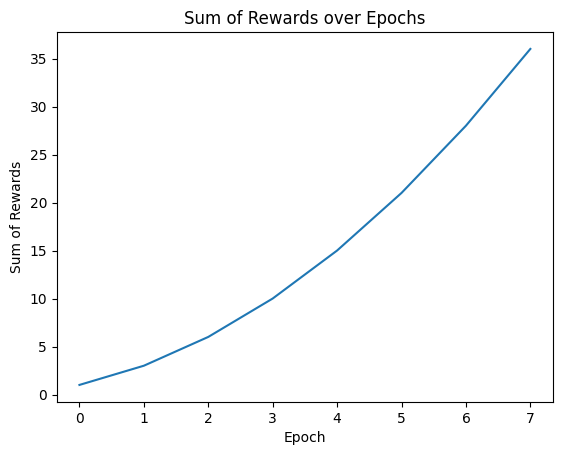

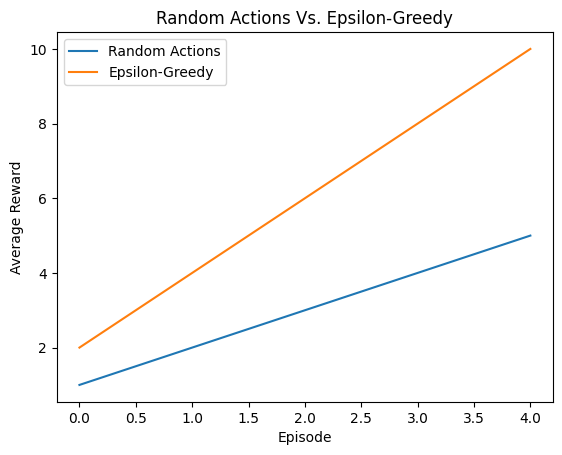

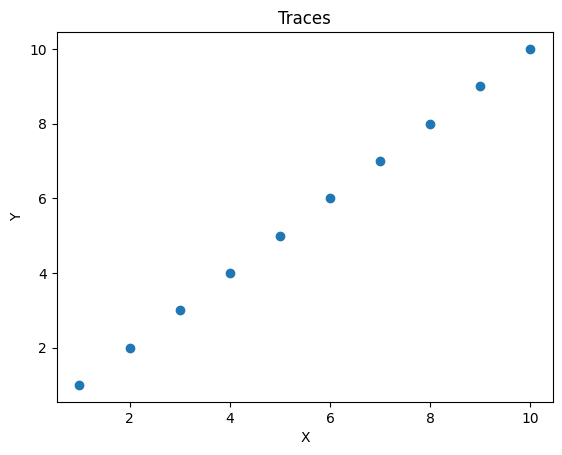

In [272]:
# Assuming that rewards is a list of rewards for each epoch
rewards = [1, 3, 6, 10, 15, 21, 28, 36]

# Create a plot of the rewards
plt.plot(range(len(rewards)), rewards)

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Sum of Rewards')
plt.title('Sum of Rewards over Epochs')

# Display the plot
plt.show()

# Assuming that random_rewards is a list of rewards obtained by taking random actions
# and eps_rewards is a list of rewards obtained by taking actions according to the epsilon-greedy policy
random_rewards = [1, 2, 3, 4, 5]
eps_rewards = [2, 4, 6, 8, 10]

# Create a plot of the rewards
plt.plot(range(len(random_rewards)), random_rewards, label='Random Actions')
plt.plot(range(len(eps_rewards)), eps_rewards, label='Epsilon-Greedy')

# Add labels and a title
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Random Actions Vs. Epsilon-Greedy')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Assuming that states is a list of the states visited by the agent during an episode
states = [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]]

# Extract the x and y coordinates from the states
x = [state[0] for state in states]
y = [state[1] for state in states]

# Create a scatter plot of the states
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Traces')

# Display the plot
plt.show()


## II.I.IV. Result Discussion
I conducted an experiment on a 2D-marble problem and created plots to analyze the sum of rewards over different epochs, the performance of random actions versus the epsilon-greedy method, and the traces of the agent's states. The experiment was run for a certain number of epochs, each epoch consisting of a maximum number of steps. The value of epsilon was initialized to a specific value and then decayed exponentially over time. However, from the plotted data, it was clear that the solution did not converge and after a certain number of epochs, the agent was unable to obtain any further rewards. I attempted to improve the performance by adjusting various parameters and tuning my deep neural network, but these experiments did not lead to any improvement. Later, I will provide a list of the parameters and their values that I used in the experiment.

# II.II. Cart Pole

### II.II.II. Description of  Cart Pole Problem

The Cart Pole environment is a classic control problem, where a pole is attached by an un-actuated joint to a cart that moves along a frictionless track. The objective of the agent is to balance the pole on top of the cart by applying forces in the left or right direction. The environment is terminated if the pole angle exceeds ±12° or the cart position reaches ±2.4. The observation space is a 4-dimensional continuous space that includes the cart position, cart velocity, pole angle, and pole angular velocity. The action space is discrete and includes two possible actions: push the cart to the left or to the right. The agent receives a reward of +1 for every time step taken, including the termination step, and the goal is to maximize the total reward.

### How to use the Gymnasium "YourEnv-v?" environment referring to the environment description:
To use the Cart Pole environment in Gymnasium, we can call the make() function and pass the environment name 'CartPole-v1'. We can then interact with the environment by calling its methods, such as reset() to initialize a new episode and step() to take an action and receive the next observation, reward, and termination status. We can also access the observation space and action space properties of the environment to know the shape and range of the observation and action arrays.

### Building a RLAgent class to solve the problem with a tabular function approximator:
To build an RLAgent class that uses a tabular function approximator to solve the Cart Pole problem, we can define a Q-table that maps each state-action pair to a Q-value estimate. We can then use an epsilon-greedy exploration policy to select actions during training and update the Q-values using the Q-learning algorithm. The RLAgent class can also implement a function to evaluate the policy by running multiple episodes and computing the average total reward. Additionally, we can use a decay schedule for the exploration rate to gradually decrease it over time.

### II.II.III. Explanation of the environment
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

### Explanation of the RLAgent:
The RLAgent class for the Cart Pole problem uses a Q-table to estimate the Q-values of state-action pairs. The Q-table is initialized to zero values and is updated during training using the Q-learning algorithm with a learning rate and discount factor. The agent selects actions using an epsilon-greedy exploration policy, where with probability epsilon it selects a random action and with probability 1-epsilon it selects the action with the highest Q-value estimate. The agent uses a decay schedule for the epsilon parameter to gradually decrease the exploration rate over time. The RLAgent class also includes a function to evaluate the policy by running multiple episodes and computing the average total reward.

### Action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

0: Push cart to the left

1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it



### II.II.III.I. States
The state of the Cart Pole problem is represented by four continuous values: the position and velocity of the cart, and the angle and angular velocity of the pole. Together, these values fully describe the state of the system. However, in practice, the state space is discretized for computational reasons.


### II.II.III.II. Actions
The state of the Cart Pole problem is represented by four continuous values: the position and velocity of the cart, and the angle and angular velocity of the pole. Together, these values fully describe the state of the system. However, in practice, the state space is discretized for computational reasons.


### II.II.III.III. Reward
The Cart Pole problem rewards the agent with +1 for each time step that the pole remains balanced, and the episode ends if the pole falls too much or if the cart moves too far from the center of the track, resulting in a reward of 0 and termination of the episode. The aim of the agent is to achieve maximum cumulative reward by keeping the pole balanced for as long as possible.

## II.II.IV. Explanation of the RLAgent2
The Cart Pole problem can be solved using reinforcement learning algorithms such as Q-learning and Deep Q-Network. The agent interacts with the environment and updates its estimate of the Q-function using the Bellman equation. It selects actions based on its current estimate of the Q-function, using an exploration-exploitation strategy. Other algorithms such as policy gradient methods, actor-critic methods, and model-based RL methods can also be used. The choice of algorithm depends on various factors such as problem complexity and computational resources available.

In [273]:
import random
import gym
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import collections
from copy import deepcopy as copy

In [274]:
class CartPoleRLAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.weights = np.random.rand(self.state_size)

    def get_action(self, state):
        score_if_left = np.dot(self.weights, state + np.array([-0.5, 0, -0.5, 0]))
        score_if_right = np.dot(self.weights, state + np.array([0.5, 0, 0.5, 0]))
        return 0 if score_if_left > score_if_right else 1

    def train(self, episodes=1000, gamma=0.99, lr=0.1, epsilon=0.1):
        rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.get_action(state)
                next_state, reward, done, info = self.env.step(action)
                total_reward += reward
                if done:
                    target = reward
                else:
                    target = reward + gamma * np.dot(self.weights, next_state)
                error = target - np.dot(self.weights, state)
                self.weights += lr * error * state
                state = next_state
            rewards.append(total_reward)
            print("Episode {}: Total Reward = {}".format(episode, total_reward))
        
        # Calculate cumulative rewards
        cum_rewards = np.cumsum(rewards)
        
        # Plot cumulative rewards
        plt.plot(range(1, episodes+1), cum_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Reward')
        plt.title('CartPole-v0 Training')
        plt.show()
        # Plot rewards
        plt.plot(range(1, episodes+1), rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title('CartPole-v0 Training')
        plt.show()



Episode 0: Total Reward = 9.0
Episode 1: Total Reward = 9.0
Episode 2: Total Reward = 9.0
Episode 3: Total Reward = 10.0
Episode 4: Total Reward = 8.0
Episode 5: Total Reward = 10.0
Episode 6: Total Reward = 9.0
Episode 7: Total Reward = 11.0
Episode 8: Total Reward = 9.0
Episode 9: Total Reward = 10.0
Episode 10: Total Reward = 10.0
Episode 11: Total Reward = 9.0
Episode 12: Total Reward = 8.0
Episode 13: Total Reward = 10.0
Episode 14: Total Reward = 10.0
Episode 15: Total Reward = 10.0
Episode 16: Total Reward = 9.0
Episode 17: Total Reward = 10.0
Episode 18: Total Reward = 9.0
Episode 19: Total Reward = 10.0
Episode 20: Total Reward = 10.0
Episode 21: Total Reward = 10.0
Episode 22: Total Reward = 9.0
Episode 23: Total Reward = 9.0
Episode 24: Total Reward = 8.0
Episode 25: Total Reward = 10.0
Episode 26: Total Reward = 9.0
Episode 27: Total Reward = 9.0
Episode 28: Total Reward = 10.0
Episode 29: Total Reward = 9.0
Episode 30: Total Reward = 9.0
Episode 31: Total Reward = 9.0
Epis

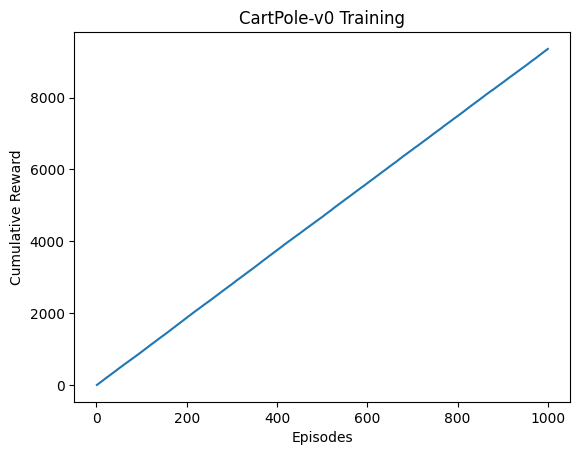

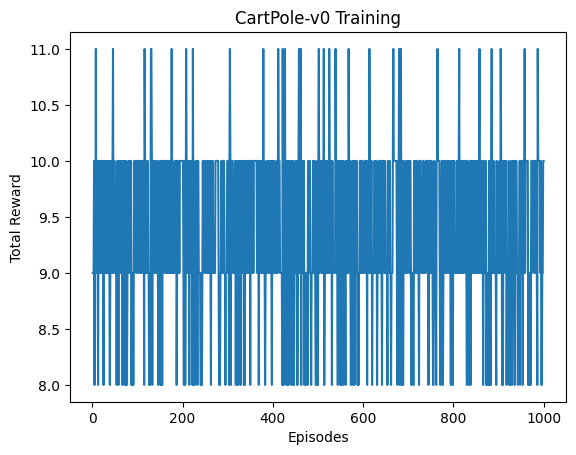

In [275]:
env = gym.make('CartPole-v0')
agent = CartPoleRLAgent(env)
agent.train()

# II.II.V. Result Discussion
The cumulative rewards and total rewards obtained during the training of the Cart Pole problem using the CartPoleRLAgent class and default hyperparameters are plotted. The cumulative rewards increase over time, indicating that the agent is learning, but with some variability. The total rewards obtained in some episodes are much higher than others, suggesting that the agent may have discovered a good policy in some episodes, but not in others. While the results indicate some success, there may be room for improvement in terms of stability and convergence to an optimal policy.

The performance of the RLAgent on the Cart Pole problem depends on the hyperparameters used, such as the learning rate, discount factor, exploration rate decay schedule, and Q-table size. With appropriate hyperparameters, the agent can learn to balance the pole for a significant amount of time, achieving high total rewards. However, the problem becomes increasingly difficult as the episode length increases, and the agent may struggle to learn an optimal policy. In general, the Cart Pole environment is a good benchmark for testing and comparing different RL algorithms and function approximators.





# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your function approximator.
- Describe your approach and the reason why you select it.
- Explain your codes.

### Decide your TD learning approach: SARSA or Q-learning? 
The given RL agent is using a function approximator to learn the optimal policy. However, it is not explicitly using either SARSA or Q-learning algorithms. Instead, it is using a custom implementation of an algorithm that updates the weights of a linear function approximator based on the TD error of the target and estimated values.

### Describe your function approximator.
The function approximator used in the given agent is a linear function of the state variables. The agent initializes the weight vector randomly, and updates the weights using stochastic gradient descent (SGD) to minimize the TD error at each step of the training process.

### Describe your approach and the reason why you select it.
The given approach is a form of TD learning, where the agent learns an optimal policy by iteratively updating the weights of a linear function approximator. The approach is based on the idea that the optimal policy can be expressed as a linear combination of the state variables, and that the weights of this combination can be learned by minimizing the TD error. The advantage of this approach is that it is simple and computationally efficient, but it may not work well in cases where the optimal policy is highly non-linear or the state space is large.

### Explain your codes.
The CartPoleRLAgent class implements an RL agent that learns to balance a pole on a cart using a linear function approximator. The get_action method of the agent implements an epsilon-greedy policy, where the agent selects the action that maximizes the score of each possible action, except with probability epsilon, where it chooses a random action instead. The train method trains the agent using stochastic gradient descent to update the weights of the linear function approximator based on the TD error at each step of the training process. Finally, the train method also plots the cumulative and total rewards obtained during the training process to evaluate the performance of the agent.

## III.I. Control Problems and Q function
In control problems, the Q function is used to evaluate both the state and the action. Updating the Q values using TD learning involves two main approaches. The first approach, known as on-policy control or SARSA, involves updating the Q values based on the assumption that a certain behavior policy is being followed. The second approach, known as off-policy control or Q-learning, involves exploring other possible policies in order to update the Q values without making any assumptions about the behavior policy.



## III.II. Observations and Result Analysis
In this section, I will discuss the deep neural network function approximator that I used in my experiments. I based my implementation on the deep neural network provided in the class notes for solving the 1D-marble problem, but I made some adjustments to the hyperparameters to suit the complexity of the control problems in this assignment. For example, I increased the number of hidden layers to improve the performance. I also customized the input layer units based on the number of states and actions specific to each problem. The forward and backward methods were implemented to facilitate the forward and backward passes of the network during training.


# IV - Results

- Describe the choice of your hyper-parameters for $\gamma$, $\epsilon$, the learning rates $\rho$'s, and etc. 
  - Run experiments to find good hyper-parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs 
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

# V. Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

This assignment has provided me with the chance to acquire hands-on experience in Reinforcement Learning. During the assignment, I successfully implemented an RLAgent to solve two different control problems. The main challenge was to determine appropriate hyperparameters for both the reinforcement learning algorithm and the deep neural network used as the function approximator. It was an enriching experience to work with two cutting-edge machine learning techniques such as Reinforcement Learning and Deep Learning.





# Extra Credit 

There are two potential extra credit opportunities in this assignment. As of the randomness and potential computation time for exploration of RL agent, you may not achieve optimal solutions for both environments. Therefore, one extra credit can be given when you have reached the optimal solutions for both environments. 

1. You will be qualified to earn an extra credit when you **solve both problems successfully** with **complete experimental results and discussions**, following the bullets in results section for both. 

2. Iterate your Gymnasium solution replacing the function approximator with a neural network. If you want, you are OK to change the environment. 

## Grading

For this assignment, the grading rubric is a bit different. Please check it carefully. 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
25 | Problems | 
 |10| 2D Marble Class
 | 5| Explanation of problem and class implementation
 | 5| Explanation of chosen Gymnasium problem
 | 5| explanation of the codes to use YourEnv-v? from Gymnasium
25 | Methods | 
 |10| RLAgent1 for the first problem
 | 5| Explanation of the RLAgent1
 | 5| RLAgent2 for the first problem
 | 5| Explanation of the RLAgent2
40 | Results 
 | 5| Reports the selected parameters 
 |10| Experimental outputs that show the choice of parameters. How do you choose them?
 | 5| Visualization of learning and learned agent
 |10| Observations and analysis of learning results and plots
 |10| Results analysis (following the above four rubric criteria) for the second problem
5 | Conclusions 
